### Finite difference methods (FDM) for the Black-Scholes PDE.

#### 1. Black-Scholes PDE

We begin with the Black-Scholes PDE for the price $V(S, t)$ of a European option:

$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$$

This is a parabolic PDE, similar to the heat equation but with non-constant coefficients. 

One can transform this equation by a simple change of variables:

$$\tau = T - t$$
$$x = \ln(S)$$
$$u(x, \tau) = V(S, t) = V(e^x, T - \tau)$$

B-S equation transforms to:

$$\frac{\partial u}{\partial \tau} = \frac{1}{2} \sigma^2 \frac{\partial^2 u}{\partial x^2} + \left(r - \frac{1}{2} \sigma^2\right) \frac{\partial u}{\partial x} - r u$$

Which has the form of convection-diffusion-reaction equation:

$$u_\tau = D u_{xx} + a u_x + b u$$

Where:
- $D = \frac{1}{2} \sigma^2$ (diffusion)
- $a = r - \frac{1}{2} \sigma^2$ (drift)
- $b = -r$ (decay)

If we eliminate the $u_x$ and $u$ terms, we get a pure heat equation:

$$u_\tau = D u_{xx}$$

This elimination can be done by choosing appropriate $\alpha$ and $\beta$ for the transformation below:

$$u(x, \tau) = e^{\alpha x + \beta \tau} w(x, \tau)$$

#### 2. Discretization of Black-Scholes PDE | European Options

In this project, we will solve Black-Scholes equation directly in terms of $S$.

Firstly, let us discretize the continuous domain:

- Price axis $S \in [0, S_{\text{max}}]$ is divided into $M$ steps
- Time axis $t \in [0, T]$ is divided into $N$ steps

We define:
- $\Delta S = \frac{S_{\text{max}}}{M}$
- $\Delta t = \frac{T}{N}$

Now let:
- $V_i^n$ be the numerical approximation to $V(S_i, t_n)$

##### 2.1 Explicit method

When pricing European options, we iteratively move backwards in time: start from option price at maturity, which is known, and move backwards in time from maturity to present moment.

Introduce time to maturity:

$$\tau = T - t$$

B-S equation transforms to:

$$\frac{\partial V}{\partial \tau} = \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V$$

Replace partial derivatives with finite differences:

- Partial time derivative (forward difference):
$$\frac{\partial V}{\partial \tau} \approx \frac{V_i^{n+1} - V_i^n}{\Delta \tau}$$

- First spatial derivative (central difference):
$$\frac{\partial V}{\partial S} \approx \frac{V_{i+1}^n - V_{i-1}^n}{2 \Delta S}$$

- Second spatial derivative:
$$\frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1}^n - 2 V_i^n + V_{i-1}^n}{\Delta S^2}$$

After rearanging terms and solving for $V_i^{n+1}$ we get:

$$V_i^{n+1} = a_i V_{i-1}^n + (1 + b_i) V_i^n + c_i V_{i+1}^n$$

Where coefficients:
$$a_i = \frac{1}{2} \Delta \tau \left( \sigma^2 i^2 - r i \right)$$
$$b_i = - \Delta \tau \left( \sigma^2 i^2 + r \right) $$
$$c_i = \frac{1}{2} \Delta \tau \left( \sigma^2 i^2 + r i \right)$$

**Boundary conditions**

For a Call Option:
- As $S \to 0$, the call becomes worthless $V(0, t) = 0$
- As $S \to \infty$, the option behaves like $S - X e^{-r(T - t)}$

For a Put Option:
- As $S \to 0$, option behaves like $V(0, t) = X e^{-r(T - t)}$
- As $S \to \infty$, the put becomes worthless $V(S_{max}, t)=0$

Thus, by knowing the option price at time $t_n$ one can directly compute the option price at time $t_{n+1}$.

The explicit method requires a very small dt due to the CFL (Courant–Friedrichs–Lewy) condition.

$$\Delta \tau \leq \frac{1}{\sigma^2 M^2}$$

Properties:
- It is simple to implement
- Conditionally stable: requires small time steps to avoid instability
- Stability condition: $\Delta \tau \leq \frac{1}{\sigma^2 M^2}$

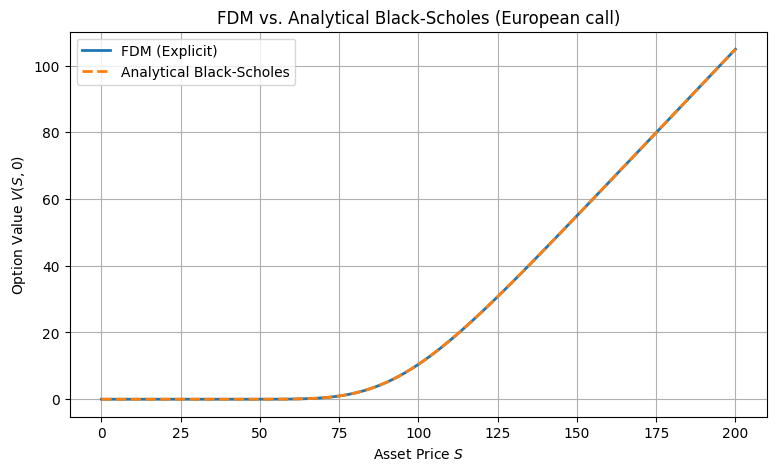

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.2
call_or_put = "call"

M = 100
N = 1000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M+1)

stability_condition = dt - 1 / (sigma ** 2 * M ** 2)

if stability_condition >= 0:
    print("Stability condition is not satisfied.")

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M)
a = 0.5 * dt * (sigma**2 * i**2 - r * i)
b = 1 - dt * (sigma**2 * i**2 + r)
c = 0.5 * dt * (sigma**2 * i**2 + r * i)

for n in range(1, N+1):
    V_old = V.copy()
    V[1:M] = a * V_old[:M-1] + b* V_old[1:M] + c* V_old[2:]

    if call_or_put == "call":
        V[0] = 0
        V[M] = S_max - X * np.exp(-r * n * dt)
    elif call_or_put == "put":
        V[0] = X * np.exp(-r * n * dt)
        V[M] = 0
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def black_scholes_european_options(S0, X, T, r, sigma, which="call"):

    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if which == "call":
        price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S, V, label='FDM (Explicit)', linewidth=2)
plt.plot(S, V_exact, '--', label='Analytical Black-Scholes', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'FDM vs. Analytical Black-Scholes (European {call_or_put})')
plt.legend()
plt.grid(True)
plt.show()

##### 2.2 Implicit method

$$\frac{\partial V}{\partial \tau} = \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V$$

As in Explicit method, we replace partial derivatives with finite differences

But in this case, instead of forward difference, we use backward difference in time derivative:

- Partial time derivative (backward difference):
$$\frac{\partial V}{\partial \tau} \approx \frac{V_i^{n} - V_i^{n-1}}{\Delta \tau}$$

- First spatial derivative (central difference):
$$\frac{\partial V}{\partial S} \approx \frac{V_{i+1}^n - V_{i-1}^n}{2 \Delta S}$$

- Second spatial derivative:
$$\frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1}^n - 2 V_i^n + V_{i-1}^n}{\Delta S^2}$$

After rearanging terms, we get the equation that can be solved for $V_i^{n+1}$:

$$ -a_i V_{i-1}^{n+1} + (1 - b_i) V_i^{n+1} - c_i V_{i+1}^{n+1} = V_i^n$$

where coefficients have the same form as in Explicit method.

It can be presented in the matrix form:

$$A \mathbf{V}^n = \mathbf{V}^{n-1}$$

**NB**: $A$ is a rectangular matrix, which can be transformed to the square tridiagonal invertable matrix, by introducing boundary vector $\mathbf{b}$:

$$\tilde{A} \mathbf{V}^n = \mathbf{V}^{n-1} + \mathbf{b}$$

Properties:
- Requires solving a tridiagonal system at each time step
- Unconditionally stable
- Can be less accurate than Crank-Nicolson
- First order in time, second order in space (like explicit method)

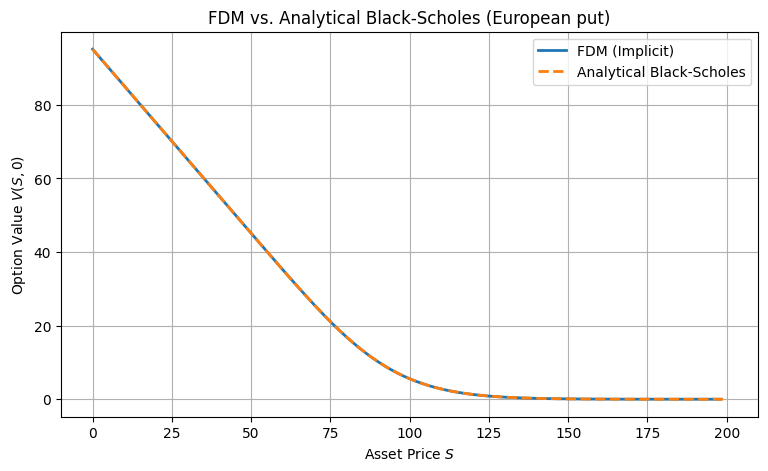

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import csc_matrix, lil_matrix
from scipy.sparse.linalg import spsolve

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.2
call_or_put = "put"

M = 100
N = 1000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M+1, endpoint=True)

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M)
alpha = -0.5 * dt * (sigma**2 * i**2 - r * i)
beta = 1 + dt * (sigma**2 * i**2 + r)
gamma = -0.5 * dt * (sigma**2 * i**2 + r * i)

A = lil_matrix((M-1, M-1))

for i in range(M-1):
    A[i, i] = beta[i]

for i in range(M-2):
    A[i, i+1] = gamma[i]
    A[i+1, i] = alpha[i + 1]

for n in range(1, N+1):

    rhs = V[1:M]
    if call_or_put == "call":
        rhs[0] -= alpha[0] * 0
        rhs[-1] -= gamma[-1] * (S_max - X * np.exp(-r * (n * dt)))
    elif call_or_put == "put":
        rhs[0] -= alpha[0] * X * np.exp(-r * (n * dt))
        rhs[-1] -= gamma[-1] * 0
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    V[1:M] = spsolve(csc_matrix(A), rhs)

    # Boundary values
    if call_or_put == "call":
        V[0] = 0
        V[M] = S_max - X * np.exp(-r * (n * dt))
    elif call_or_put == "put":
        V[0] = X * np.exp(-r * (n * dt))
        V[M] = 0
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def black_scholes_european_options(S0, X, T, r, sigma, which="call"):

    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if which == "call":
        price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S[:-1], V[:-1], label='FDM (Implicit)', linewidth=2)
plt.plot(S, V_exact, '--', label='Analytical Black-Scholes', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'FDM vs. Analytical Black-Scholes (European {call_or_put})')
plt.legend()
plt.grid(True)
plt.show()

##### 2.3 Crank-Nicolson method

**Crank-Nicolson** is a time-centered (second-order !!) scheme. It is:
- More accurate than both explicit and implicit methods (second-order in both time and space).
- Unconditionally stable (like implicit).
- Symmetric: It averages the explicit and implicit methods.

$$\frac{\partial V}{\partial \tau} = \mathcal{L} \left( V\right) = \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V$$

Crank-Nicolson applies a trapezoidal rule (time averaging) to the full PDE:

$$\frac{V_i^{n+1} - V_i^n}{\Delta t} = \frac{1}{2}\left[\mathcal{L} V_i^{n+1} + \mathcal{L} V_i^n \right]$$

Where $\mathcal{L}$ is the Black-Scholes operator.

After rearanging terms, we get the equation that can be solved for $V_i^{n+1}$:

$$ -\alpha_i V_{i-1}^{n+1} + (1 - \beta_i) V_i^{n+1} - \gamma_i V_{i+1}^{n+1} = \alpha_i V_{i-1}^n + (1 + \beta_i) V_i^n + \gamma_i V_{i+1}^n$$

where:

$$\alpha_i = \frac{1}{4} \Delta{\tau} \left (\sigma^2 i^2 - r i \right)$$
$$\beta_i = -\frac{1}{2} \Delta{\tau} \left (\sigma^2 i^2 + r \right)$$
$$\gamma_i = \frac{1}{4} \Delta{\tau} \left (\sigma^2 i^2 + r i \right)$$

It can be presented in the matrix form:

$$A \mathbf{V}^{n + 1} = B \mathbf{V}^{n} + \mathbf{b}$$

where $A$ and $B$ are tridiagonal matrices, and $\mathbf{b}$ serves a purpose of the boundary vector, as described in implicit method.

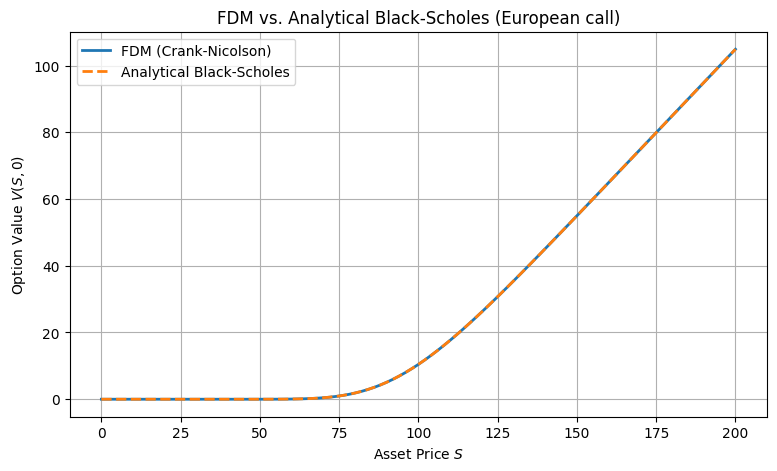

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse.linalg import spsolve

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.2
call_or_put = "call"

M = 100
N = 1000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M + 1)

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M)

alpha = 0.25 * dt * (sigma**2 * i**2 - r * i)
beta = -0.5 * dt * (sigma**2 * i**2 + r)
gamma = 0.25 * dt * (sigma**2 * i**2 + r * i)

A = lil_matrix((M-1, M-1))
B = lil_matrix((M-1, M-1))

for i in range(M-1):
    A[i, i] = 1 - beta[i]
    B[i, i] = 1 + beta[i]

for i in range(M-2):
    A[i, i+1] = -gamma[i]
    A[i+1, i] = -alpha[i + 1]

    B[i, i+1] = gamma[i]
    B[i+1, i] = alpha[i + 1]

A = csc_matrix(A)
B = csc_matrix(B)

for n in range(1, N+1):
    rhs = B @ V[1:M]

    if call_or_put == "call":
        rhs[0] += alpha[1] * 0 + alpha[1] * 0
        rhs[-1] += gamma[-1] * (S_max - X * np.exp(-r * (n-1) * dt)) + gamma[-1] * (S_max - X * np.exp(-r * n * dt))
    elif call_or_put == "put":
        rhs[0] += alpha[0] * (X * np.exp(-r * (n-1) * dt)) + alpha[0] * (X * np.exp(-r * n * dt))
        rhs[-1] += gamma[-1] * 0 + gamma[-1] * 0

    V[1:M] = spsolve(A, rhs)

    if call_or_put == "call":
        V[0] = 0
        V[M] = S_max - X * np.exp(-r * n * dt)
    elif call_or_put == "put":
        V[0] = X * np.exp(-r * n * dt)
        V[M] = 0

def black_scholes_european_options(S0, X, T, r, sigma, which="call"):
    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if which == "call":
        price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S, V, label='FDM (Crank-Nicolson)', linewidth=2)
plt.plot(S, V_exact, '--', label='Analytical Black-Scholes', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'FDM vs. Analytical Black-Scholes (European {call_or_put})')
plt.legend()
plt.grid(True)
plt.show()


### 3. American options

We enforce the early exercise constraint:

$$V(S, t) \geq \max(X - S, 0) \quad \text{for a put}$$
$$V(S, t) \geq \max(S - X, 0) \quad \text{ for a call}$$

#### 3.1 Explicit method

The only difference we make, is that after each evalution of $V^{n+1}_i$ we force the constraint

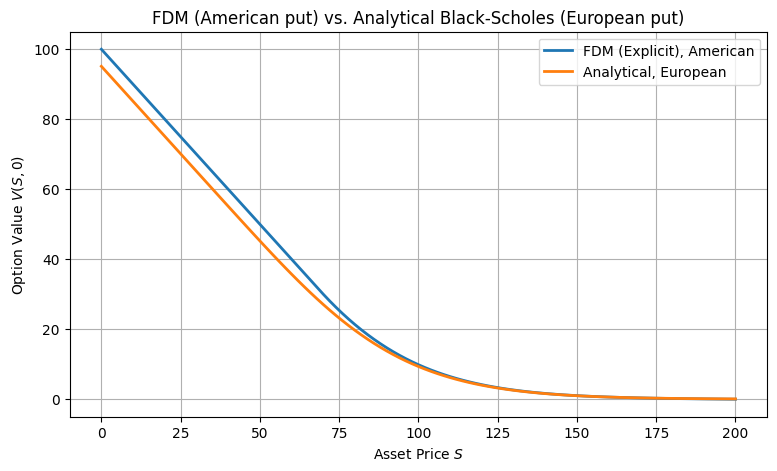

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.3
call_or_put = "put"

M = 100
N = 1000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M+1)

stability_condition = dt - 1 / (sigma ** 2 * M ** 2)

if stability_condition >= 0:
    print("Stability condition is not satisfied.")

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M)
a = 0.5 * dt * (sigma**2 * i**2 - r * i)
b = 1 - dt * (sigma**2 * i**2 + r)
c = 0.5 * dt * (sigma**2 * i**2 + r * i)

for n in range(1, N+1):
    V_old = V.copy()
    V[1:M] = a * V_old[:M-1] + b * V_old[1:M] + c * V_old[2:]

    if call_or_put == "call":
        V[0] = 0
        V[M] = S_max - X * np.exp(-r * n * dt)
    elif call_or_put == "put":
        V[0] = X * np.exp(-r * n * dt)
        V[M] = 0
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    # American option constraint (early exercise)
    if call_or_put == "call":
        V = np.maximum(V, S - X)
    elif call_or_put == "put":
        V = np.maximum(V, X - S)

def black_scholes_european_options(S0, X, T, r, sigma, which="call"):

    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if which == "call":
        price = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S, V, label='FDM (Explicit), American', linewidth=2)
plt.plot(S, V_exact, label='Analytical, European', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'FDM (American {call_or_put}) vs. Analytical Black-Scholes (European {call_or_put})')
plt.legend()
plt.grid(True)
plt.show()

#### 3.2 Implicit method with PSOR

Just like in Implicit method for European options, we start from the equation:

$$A \mathbf{V}^n = \mathbf{V}^{n-1} + \mathbf{b}$$

where $A$ is a tridiagonal matrix, and $\mathbf{b}$ is a boundary vector.

At each time step, boundary values are updated explicitly:
- For a put:

$$V(0,t) = X e^{-r(T-t)}, \quad V(S_{\max}, t) = 0$$

- For a call:

$$V(0,t) = 0, \quad V(S_{\max}, t) = S_{\max} - X e^{-r(T-t)}$$

Start at the initial guess: $V^{(0)}_i = V^n_i$ and iterate in the following way (**PSOR Iterator** or **Gauss-Seidel with projection**):

$$V_i^{(k+1)} = \max\left( \text{payoff}_i, (1 - \omega)V_i^{(k)} + \frac{\omega}{A_{ii}} \left(b_i - \sum_{j < i} A_{ij} V_j^{(k+1)} - \sum_{j > i} A_{ij} V_j^{(k)}\right) \right)$$

where $\omega \in (1, 2)$ is an over-relaxation parameter. We set it to $\omega = 1.2$. Then iterate until convergence:

$$ \| V^{(k+1)} - V^{(k)} \|_\infty < \varepsilon, \quad \varepsilon = 10^{-8}$$

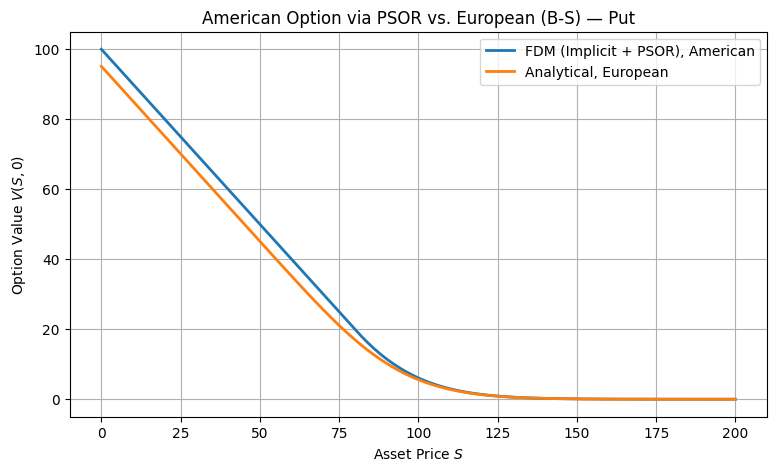

In [252]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S_max = 200
X = 100
T = 1.0
r = 0.05
sigma = 0.2
call_or_put = "put"

M = 100
N = 1000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M+1)
omega = 1.2
tol = 1e-8
max_iter = 10000

if call_or_put == "call":
    V = np.maximum(S - X, 0)
elif call_or_put == "put":
    V = np.maximum(X - S, 0)
else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

i = np.arange(1, M)
alpha = -0.5 * dt * (sigma**2 * i**2 - r * i)
beta = 1 + dt * (sigma**2 * i**2 + r)
gamma = -0.5 * dt * (sigma**2 * i**2 + r * i)

for n in range(1, N+1):
    payoff = X - S[1:M] if call_or_put == "put" else S[1:M] - X
    b = V[1:M].copy()

    if call_or_put == "call":
        b[-1] -= gamma[-1] * (S_max - X * np.exp(-r * n * dt))
    elif call_or_put == "put":
        b[0] -= alpha[0] * (X * np.exp(-r * n * dt))
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    V_old = V[1:M].copy()
    for it in range(max_iter):
        V_new = V_old.copy()
        for j in range(M-1):
            lhs = b[j]
            if j > 0:
                lhs -= alpha[j] * V_new[j-1]
            if j < M-2:
                lhs -= gamma[j] * V_old[j+1]
            V_new[j] = max(payoff[j], (1 - omega) * V_old[j] + omega / beta[j] * lhs)
        if np.linalg.norm(V_new - V_old, ord=np.inf) < tol:
            break
        V_old = V_new.copy()

    V[1:M] = V_new

    if call_or_put == "call":
        V[0] = 0
        V[M] = np.maximum(S_max - X * np.exp(-r * (n * dt)), S[M] - X)
    elif call_or_put == "put":
        V[0] = np.maximum(X * np.exp(-r * (n * dt)), X - S[0])
        V[M] = 0
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

# Exact European price for comparison
def black_scholes_european_options(S0, X, T, r, sigma, which="call"):
    d1 = (np.log(S0 / X + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if which == "call":
        return S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif which == "put":
        return X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

V_exact = black_scholes_european_options(S, X, T, r, sigma, which=call_or_put)

plt.figure(figsize=(9, 5))
plt.plot(S, V, label='FDM (Implicit + PSOR), American', linewidth=2)
plt.plot(S, V_exact, label='Analytical, European', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title(f'American Option via PSOR vs. European (B-S) — {call_or_put.capitalize()}')
plt.legend()
plt.grid(True)
plt.show()